In [1]:
# Install all the required libraries, including plotting tools
# !pip install numpy pandas scikit-learn statsmodels econml lightgbm matplotlib seaborn

In [2]:
# Necessary imports

import numpy as np
import pandas as pd
import statsmodels.api as sm
from lightgbm import LGBMRegressor, LGBMClassifier
from econml.dml import LinearDML
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

## Causal ML:

Causal ML particularly useful when:

1. Large number of features
2. Complex functional form of Confounders.

Let's set up the following simulated data to showcase the advantages of Causal ML, more specifically Double-Debiased Machine Learning.

## Data Generating Process (DGP)

The simulation follows these key steps:

### 1. Covariates (Features)
First, we generate a matrix of 100 covariates, $\mathbf{X}$, for each of the $N$ individuals. Each covariate is drawn independently from a standard normal distribution:

$$X_{ij} \sim \mathcal{N}(0, 1) \quad \text{for } j = 0, 1, \dots, 99$$

***

### 2. Confounding and Treatment Assignment
A complex, non-linear **confounding term**, $C_i$, is created using the first four covariates. This term will influence both the treatment assignment and the outcome, which is the definition of a confounder.

The confounding term $C_i$ is defined as:
$$C_i = \sin(2X_{i0}) + \cos(2X_{i1}) + X_{i2}^3 + 0.5 X_{i3}^2$$
The **treatment assignment**, $D_i$, is then determined by a Bernoulli trial where the probability of receiving the treatment (the propensity score, $e(\mathbf{X}_i)$) is a logistic function of this confounding term.

$$P(D_i=1 | \mathbf{X}_i) = e(\mathbf{X}_i) = \frac{1}{1 + \exp(-1.5(C_i - 0.5))}$$
So, $D_i \sim \text{Bernoulli}(e(\mathbf{X}_i))$.

***

### 3. Outcome Model
Finally, the **outcome model** for $Y_i$ is a linear combination of the treatment effect and a function of the covariates, $g(\mathbf{X}_i)$, plus a random error term.

The complete outcome model is:$$Y_i = \alpha + \tau D_i + g(\mathbf{X}_i) + \epsilon_i$$
Where the true ATE is $\tau = 10$ and the error term is drawn from a standard normal distribution, $\epsilon_i \sim \mathcal{N}(0, 1)$. 

In [3]:
# --- 1. Set up a More Robust Simulation ---

true_ate = 10.0
n_samples = 100000
n_features = 100
np.random.seed(123)

X_data = np.random.normal(0, 1, size=(n_samples, n_features))
X = pd.DataFrame(X_data, columns=[f'X{i}' for i in range(n_features)])

# --- 2. Define a DGP with STRONGER Confounding ---

# This non-linear term will now have a much larger effect
confounders = np.sin(X['X0'] * 2) + np.cos(X['X1'] * 2) + (X['X2']**3) + 0.5 * X['X3']**2

# Treatment assignment with confounding
propensity_score = 1 / (1 + np.exp(-1.5 * (confounders - 0.5)))
D = np.random.binomial(1, p=propensity_score)

# Outcome model with strong confounding
# The key insight: both treatment assignment AND outcome depend on the same confounders
g_X = 3 * confounders + 0.5 * X['X4']  # Outcome function depends on confounders
Y = true_ate * D + g_X + np.random.normal(0, 1, n_samples)

print("--- Data Simulation Setup ---")
print(f"True Average Treatment Effect (ATE): {true_ate}")
print(f"Sample size: {n_samples:,}")
print(f"Treatment prevalence: {D.mean():.3f}\n")

--- Data Simulation Setup ---
True Average Treatment Effect (ATE): 10.0
Sample size: 100,000
Treatment prevalence: 0.523



## OLS Estimation:

Let's first estimate the model with OLS. . The standard OLS approach models the outcome $Y$ as a linear function of the treatment $D$ and the covariates $\mathbf{X}$: $$ Y_i = \alpha + \tau D_i + \boldsymbol{\beta}'\mathbf{X}_i + u_i $$

The coefficient $\tau$ represents the ATE estimate. The highly non-linear DGP mechanically creates a **OVB**, yielding a biased ATE estimate. The effect of **OVB** is ambiguous, i.e. upward or downward bias. 

In [9]:
# --- 3. Model 1: Naive OLS ---

# RHS of estimation equation
X_with_const = sm.add_constant(np.c_[D, X])

# Instantiate OLS model class and fit the model
ols_model = sm.OLS(Y, X_with_const).fit()

# Extract ATE parameter
ols_ate_estimate = ols_model.params[1]

# The treatment effect is the coefficient for D, which should be index 1 (after constant)
treatment_param_idx = 1
ols_conf_interval = ols_model.conf_int().iloc[treatment_param_idx]

print("--- 1. Naive OLS Results ---")
print(f"Estimated ATE with OLS: {ols_ate_estimate:.4f}")
print(f"OLS 95% Confidence Interval: [{ols_conf_interval[0]:.4f}, {ols_conf_interval[1]:.4f}]")
print(f"Bias: {ols_ate_estimate - true_ate:.4f}")

--- 1. Naive OLS Results ---
Estimated ATE with OLS: 13.8086
OLS 95% Confidence Interval: [13.6951, 13.9220]
Bias: 3.8086


## OLS Results:

Upward bias in ATE estimates ($\hat{\tau} = 13.808>10$), where the bias is $\hat{\tau} - \tau_{\text{true}} = 3.8$. Now let's look at the result from DML.

***

## Double/Debiased Machine Learning: Estimation

1. Estimate first one flexible model for the outcome only based on confounders ($X_i$) and stores the residuals: $$ \tilde{Y} = Y - Y_{\text{predicted}}\text{.}$$

2. Trains a separate model to predict the treatment $D$ on the same confounders and calculates the residuals: $$\tilde{D} = D - D_{\text{prediction}}\text{.}$$ These residuals represent the part of the treatment that is not explained by the confounders.

By doing so we remove the effect of confounders on both the **outcome** and **treatment assignment**

**CAVEAT**: To avoid overfitting use **K-Fold crossfitting** for the predictions, split data in K-fold and use K-1 fold for training and last fold for predictions iteratively.
***

## Final Step:

**Debiased Estimation**: Run a simple linear regression on just the residuals $\tilde{Y}$ and $\tilde{D}$: $$\tilde{Y_i} = \beta_0 + \tau\tilde{D_i} + \mu_i.$$ Now $\hat{\tau}$ is our ATE coefficient.

In [10]:
# --- 4. Model 2: Double Machine Learning ---

# Instantiating the K-Fold cross-validator
cv_splitter = KFold(n_splits=5, shuffle=True, random_state=123)

# Instantiate the LinearDML model with LightGBM
est_dml = LinearDML(
    model_y=LGBMRegressor(
        n_estimators=100, 
        num_leaves=30, 
        learning_rate=0.1,
        random_state=123,
        verbosity=-1
    ),
    model_t=LGBMClassifier(
        n_estimators=100, 
        num_leaves=30, 
        learning_rate=0.1,
        random_state=123,
        verbosity=-1
    ),
    cv=cv_splitter,
    discrete_treatment=True,
    random_state=123
)

est_dml.fit(
    Y, T=D, X=X
)

ate_summary = est_dml.ate_inference(X=X)
dml_ate_estimate = ate_summary.mean_point
dml_ci_lower, dml_ci_upper = ate_summary.conf_int_mean(alpha=0.05)

print("--- 2. Double Machine Learning Results ---")
print(f"Estimated ATE: {dml_ate_estimate:.4f}")
print(f"P-value: {ate_summary.pvalue():.6f}")
print(f"95% Confidence Interval: [{dml_ci_lower:.4f}, {dml_ci_upper:.4f}]")
print(f"Bias: {dml_ate_estimate - true_ate:.4f}")

--- 2. Double Machine Learning Results ---
Estimated ATE: 9.9842
P-value: 0.000000
95% Confidence Interval: [9.9619, 10.0065]
Bias: -0.0158


## Visualize the Results

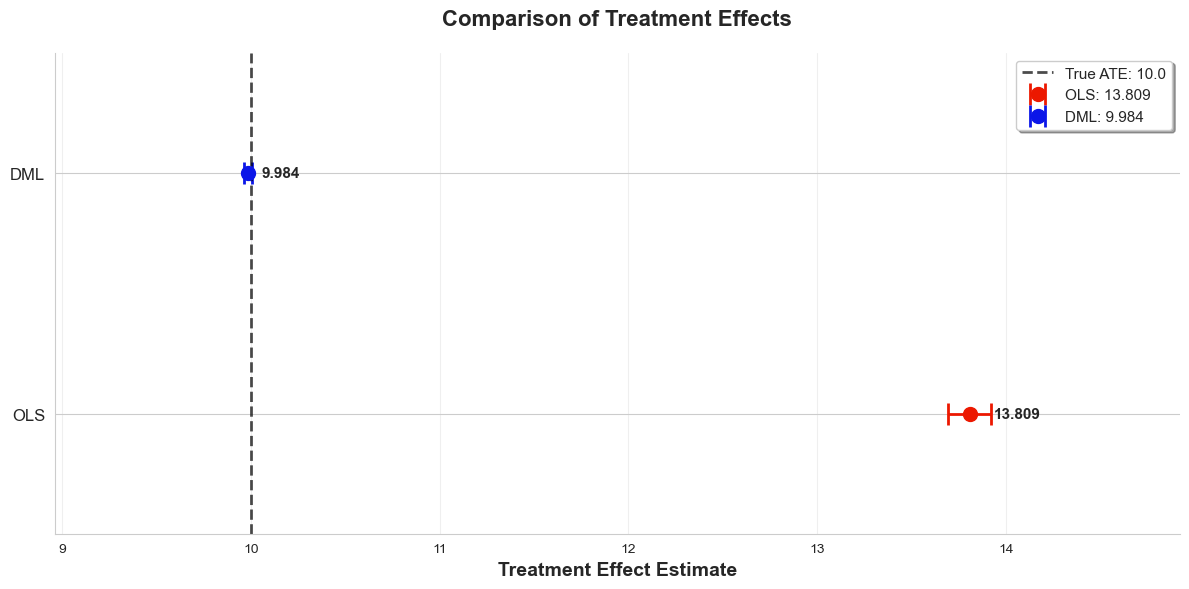

In [15]:
# --- 5. Visualize Results ---

plt.style.use('default')
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(12, 6))

# Data for plotting
methods = ['OLS', 'DML']
estimates = [ols_ate_estimate, dml_ate_estimate]
ci_lowers = [ols_conf_interval[0], dml_ci_lower]
ci_uppers = [ols_conf_interval[1], dml_ci_upper]
colors = ["#ec1800", "#0b16e8"]  # Red for biased, green for unbiased

# Create horizontal error bars
y_positions = [0, 1]
for i, (method, est, ci_low, ci_up, color) in enumerate(zip(methods, estimates, ci_lowers, ci_uppers, colors)):
    # Error bar
    ax.errorbar(est, y_positions[i], 
                xerr=[[est - ci_low], [ci_up - est]], 
                fmt='o', color=color, capsize=8, capthick=2,
                markersize=10, linewidth=2, label=f'{method}: {est:.3f}')
    
    # Add text annotation with the estimate - move OLS estimate further right
    x_offset = 17 if i == 0 else 10  # More offset for OLS (first method)
    ax.annotate(f'{est:.3f}', (est, y_positions[i]), 
                xytext=(x_offset, 0), textcoords='offset points', 
                va='center', fontsize=11, fontweight='bold')

# Add vertical line for true ATE
ax.axvline(x=true_ate, color='black', linestyle='--', linewidth=2, 
           label=f'True ATE: {true_ate}', alpha=0.7)

# Customize the plot
ax.set_yticks(y_positions)
ax.set_yticklabels(methods, fontsize=12)
ax.set_xlabel('Treatment Effect Estimate', fontsize=14, fontweight='bold')
ax.set_title('Comparison of Treatment Effects', 
             fontsize=16, fontweight='bold', pad=20)

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid for better readability
ax.grid(True, alpha=0.3, axis='x')

# Add legend
ax.legend(loc='upper right', fontsize=11, frameon=True, fancybox=True, shadow=True)

# Set x-axis limits to better show the confidence intervals
x_min = min(ci_lowers) - 1
x_max = max(ci_uppers) + 1
ax.set_xlim(x_min, x_max)

# Add some padding to y-axis
ax.set_ylim(-0.5, 1.5)

plt.tight_layout()
plt.show()